In [11]:
import numpy as np
import matplotlib.pyplot as plt
from climlab import constants as const
import xarray as xr
from climlab.solar.orbital import OrbitalTable
from climlab.solar.insolation import daily_insolation # use myenv
sys.path.insert(1, '/glade/u/home/lettier/analysis/analysis_temp-asym/pub/')
import sys
import asym_funcs as af
xr.set_options(keep_attrs=True)
from datetime import datetime
import os
import pandas as pd

Grid is evenly spaced in x, latitudes are given by np.arcsin(x)*180./np.pi

In [28]:
nx = 400.
nt = 10000.

dx = 1./nx   #grid box width
x = np.arange(-1.+dx/2.,1.+dx/2.,dx) #native grid
mylats = np.arcsin(x)*180./np.pi

dt = 1./nt
mytimes = np.arange(dt/2.,1.+dt/2.,dt)

Present-day insolation

In [30]:
ds = daily_insolation(mylats, np.linspace(0, const.days_per_year, int(nt) ))
ds = xr.DataArray(ds,dims=('lat','time'), coords = {'lat':mylats, 'time':mytimes}).to_dataset(name='S')
ds.S.attrs['units'] = 'W/m^2'
ds.S.attrs['long_name'] = 'TOA insolation'
ds.to_netcdf('../simplemodel/forcing_TOAinsolation_n800_nt10000.nc')

Fourier fits to insolation

In [5]:
for mode in [1,2,3,4,5]:
    ds_toa_fourier = af.xr_fourier_decomp(ds.time/max(ds.time), ds, mode, dim='time')
    ds_toa_fourier.to_netcdf('../simplemodel/forcing_TOAinsolation_fourier'+str(mode)+'_n800.nc')

In [6]:
kyears = np.arange( -1000., 1.)
orb = OrbitalTable.sel(kyear=kyears)
print("Currently, eccentricity={:.3f}, obliquity={:.3f}, longitude of perihelion={:.3f}".format(orb.sel(kyear=0).ecc.values,              
      orb.sel(kyear=0).obliquity.values,
      orb.sel(kyear=0).long_peri.values))

Currently, eccentricity=0.017, obliquity=23.446, longitude of perihelion=281.370


Insolation with eccentricity = 0

In [7]:
ds = daily_insolation(mylats, np.linspace(0, const.days_per_year, int(nt) ), {'ecc':0., 'obliquity':orb.sel(kyear=0).obliquity.values, 
                                              'long_peri':orb.sel(kyear=0).long_peri.values})
ds = xr.DataArray(ds,dims=('lat','time'), coords = {'lat':mylats, 'time':mytimes}).to_dataset(name='S')
ds.S.attrs['units'] = 'W/m^2'
ds.S.attrs['long_name'] = 'TOA insolation'
ds.to_netcdf('../simplemodel/forcing_TOAinsolation_zeroecc_n800.nc')

Atmospheric heat flux convergence

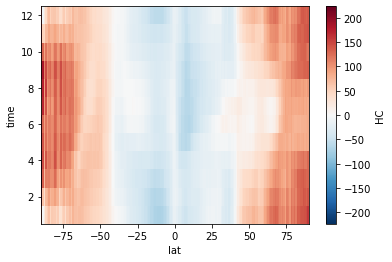

In [8]:
import scipy.io
mat = scipy.io.loadmat('/glade/work/lettier/CERES/CERES_ERA5_energy_climatology.mat')
listds = []
for var in mat:
    if '__' not in var:
        if var!='lat':
            ds = xr.DataArray(mat[var],dims=('month','lat'),coords={'month':np.arange(1,13,1),
                                                                   'lat':mat['lat'][:,0]}).to_dataset(name=var)
            listds.append(ds)
ds = xr.merge(listds)
ds = ds.rename({'month':'time'})[['CAHT_div']].rename({'CAHT_div':'HC'})
ds.HC.plot()
ds = xr.concat([ds.isel(time=-1),ds,ds.isel(time=0)],dim='time')
dummy_dates = [datetime.strptime(f,'%Y-%m-%d') for f in ['1990-12-15','1991-01-15', '1991-02-14', '1991-03-16', '1991-04-15',
               '1991-05-15', '1991-06-15', '1991-07-16', '1991-08-15',
               '1991-09-15', '1991-10-16', '1991-11-15', '1991-12-15',
               '1992-01-16']]
ds['time'] = dummy_dates 
ds = ds.resample(time="1D").interpolate("linear")
ds = ds.sel(time='1991')
ds['time'] = np.linspace(0,1,365)
ds = ds.interp(lat = mylats).interp(time = mytimes) # interp to correct lats
ds.to_netcdf('../simplemodel/forcing_ERA5_HC_n800.nc')

CERES shortwave

In [9]:
mydir = '/glade/work/lettier/CERES/'
myfiles = sorted(os.listdir(mydir))
myfiles = [f for f in myfiles if 'CERES_SYN1deg-Day' in f]
listds = []
for f in myfiles:
    listds.append(xr.open_dataset(mydir+f).mean(dim='lon'))
cds = xr.concat(listds, dim='time')

In [10]:
cds['time'] = pd.date_range(start="2001-01-01",end="2020-12-31", freq='D')

In [11]:
listds = []
for y in range(2001,2021,1):
    yds = cds.sel(time=[f for f in cds.time.values if str(y) in str(f)])
    yds['time'] = np.linspace(1,365,len(yds.time.values))
    if len(yds.time.values)==366:
        yds = yds.interp(time=np.linspace(1,365,365))
    yds['year'] = y
    yds = yds.set_coords('year')
    listds.append(yds)
cds = xr.concat(listds,dim='year').mean(dim='year')
cds['time'] = np.linspace(0,1,365)
cds = cds.interp(time=mytimes).interp(lat=mylats)

In [12]:
myvars = ['adj_atmos_sw_down_all_toa_daily','adj_atmos_sw_down_all_surface_daily',
         'adj_atmos_lw_down_all_surface_daily']
mynames = ['TOA_SW_down','SFC_SW_down','SFC_LW_down']

In [30]:
ds = cds.adj_atmos_sw_down_all_toa_daily.to_dataset(name='S')
ds['S'] = (ds.S).T
ds.S.attrs['units'] = 'W/m^2'
ds.S.attrs['long_name'] = 'TOA shortwave down'
ds.to_netcdf('../simplemodel/forcing_CERES_TOA-SW-down_n800.nc')

ds = cds.adj_atmos_sw_down_all_surface_daily.to_dataset(name='S')
ds['S'] = (ds.S).T
ds.S.attrs['units'] = 'W/m^2'
ds.S.attrs['long_name'] = 'Surface shortwave down'
ds.to_netcdf('../simplemodel/forcing_CERES_SFC-SW-down_n800.nc')

ds = cds.adj_atmos_sw_down_all_surface_daily.to_dataset(name='L')
ds['L'] = (ds.L).T
ds = ds - ds.mean(dim='time')
ds.L.attrs['units'] = 'W/m^2'
ds.L.attrs['long_name'] = 'Surface longwave down anomaly'
ds.to_netcdf('../simplemodel/forcing_CERES_SFC-LW-down_anom_n800.nc')

Zonally varying downwelling surface shortwave forcing from CERES

In [ ]:
mydir = '/glade/work/lettier/CERES/'
myfiles = sorted(os.listdir(mydir))
myfiles = [f for f in myfiles if 'CERES_SYN1deg-Day' in f]
listds = []
for f in myfiles:
    listds.append(xr.open_dataset(mydir+f))
cds = xr.concat(listds, dim='time')
cds['time'] = pd.date_range(start="2001-01-01",end="2020-12-31", freq='D')
listds = []
for y in range(2001,2021,1):
    yds = cds.sel(time=[f for f in cds.time.values if str(y) in str(f)])
    yds['time'] = np.linspace(1,365,len(yds.time.values))
    if len(yds.time.values)==366:
        yds = yds.interp(time=np.linspace(1,365,365))
    yds['year'] = y
    yds = yds.set_coords('year')
    listds.append(yds)
cds = xr.concat(listds,dim='year').mean(dim='year')
cds['time'] = np.arange(1,366,1)
cds.to_netcdf(mydir+'CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_2001-2020_climatology.nc')

In [31]:
mydir = '/glade/work/lettier/CERES/'
cds = xr.open_dataset(mydir+'CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_2001-2020_climatology.nc')

In [6]:
cds['time'] = np.linspace(0,1,365)
cds = cds.interp(time=mytimes).interp(lat=mylats)
ds = cds.adj_atmos_sw_down_all_surface_daily.to_dataset(name='S')
ds['S'] = (ds.S).T
ds.S.attrs['units'] = 'W/m^2'
ds.S.attrs['long_name'] = 'Surface shortwave down'
ds.to_netcdf('../simplemodel/forcing_CERES_SFC-SW-down_zonal-and-meridional_n800.nc')

In [43]:
cds['absorp'] =  1.- cds.adj_atmos_sw_down_all_surface_daily/cds.adj_atmos_sw_down_all_toa_daily # fraction of SW is absorbed by clouds

In [44]:
lon1, lon2 = 160,180
lat1, lat2 = 45, 55
pac = cds.where(cds.lat>20).where(cds.lat<35).where(cds.lon>195).where(cds.lon<220)
pac = pac.where(pac==pac,drop=True)
pac = pac.mean(dim=('lat','lon'))

In [45]:
lon1, lon2 = 73,95
lat1, lat2 = 20, 28
eas = cds.where(cds.lat>lat1).where(cds.lat<lat2).where(cds.lon>lon1).where(cds.lon<lon2)
eas = eas.where(eas==eas,drop=True)
eas = eas.mean(dim=('lat','lon'))

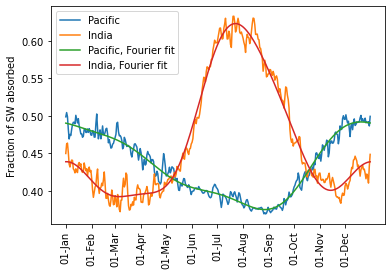

In [54]:
fig, ax = plt.subplots(1)
pac.absorp.plot(ax=ax,label='Pacific')
eas.absorp.plot(ax=ax,label='India')


pac_f = af.xr_fourier_decomp(cds.time/max(cds.time), pac, 4, dim='time')
pac_f.absorp.plot(ax=ax,label='Pacific, Fourier fit')

eas_f = af.xr_fourier_decomp(cds.time/max(cds.time), eas, 4, dim='time')
eas_f.absorp.plot(ax=ax,label='India, Fourier fit')

ax.set_xticks(af.firstofmonthind)
ax.set_xticklabels(af.firstofmonthlabel,rotation='vertical')

ax.set_ylabel('Fraction of SW absorbed')
ax.set_xlabel('')
plt.legend()
plt.show()
plt.close()

Meridionally varying heat capacity

In [1]:
c_w = 9.8
c_l = 2.1*0.16
print(c_l)


0.336


In [18]:
landfrac = xr.open_dataset('/glade/work/lettier/HADISST/landmask.nc').sftlf
garea = xr.open_dataset('/glade/work/lettier/GRIDS/areacello_1deg_HadISST_regular_grid.nc').areacello
land_area = (garea*landfrac).sum(dim='longitude')
ocean_area = (garea*(1.-landfrac)).sum(dim='longitude')
total_area = garea.sum(dim='longitude')

land_frac = (land_area/total_area).interp(latitude = mylats)
ocean_frac = (ocean_area/total_area).interp(latitude = mylats)

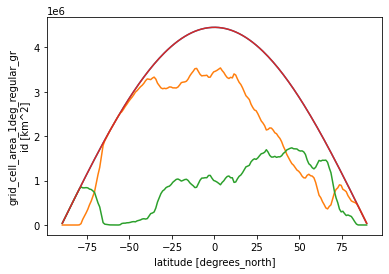

In [34]:
fig, ax = plt.subplots(1)
total_area.plot(ax=ax)
ocean_area.plot(ax=ax)
land_area.plot(ax=ax)
(ocean_area+land_area).plot(ax=ax)

plt.show()
plt.close()

In [20]:
area_weighted_cw = ocean_frac*c_w + land_frac*c_l

In [23]:
area_weighted_cw =area_weighted_cw.rename({'latitude':'lat'}).to_dataset(name='c')

In [24]:
area_weighted_cw.to_netcdf('../simplemodel/zonal_variation_in_cw_n800.nc')